In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import json
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from model import MoleculeACEDataset
from preprocessing import get_cliff_groups_test
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import sklearn
import matplotlib.gridspec as gridspec
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os
from reportlab.graphics import renderPDF
from reportlab.pdfgen import canvas
from svglib.svglib import svg2rlg

# Preprocessing

In [2]:
# CHEMBL234_Ki
# CHEMBL214_Ki
dataset = 'CHEMBL234_Ki'

In [3]:
col_dark_blue = '#0d0887'
col_medium_blue = '#6964b4'
col_violet = '#6a00a8'
col_pink = '#b12a90'
col_salmon = '#e16462'
col_orange = '#fca636'
col_yellow = '#d8e006'


In [4]:
df_test = pd.read_csv("../data/" + dataset + "/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/" + dataset + "/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test = df_test.dropna(subset=['cliff_group'])
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

df_test.head()

,smiles,exp_mean [nM],y,cliff_mol,split,y [pEC50/pKi],active,ecfp,cliff_mol_binary,similar_molecules,cliff_group
8,Cc1cccc(C(=O)NCN2CCN(c3ccccc3Cl)CC2)c1,464.00,-2.666518,0,test,6.333482,0,"[-0.06217700042172756, 3.0942948523831184, -0....",1,[9],0
9,Cc1ccc(C(=O)NCN2CCN(c3ccccc3Cl)CC2)cc1,49.00,-1.690196,0,test,7.309804,1,"[-0.06217700042172756, 3.0942948523831184, -0....",1,[8],0
15,c1ccc(CCCNCCCOc2ccccc2)cc1,17.00,-1.230449,1,test,7.769551,1,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[16, 22]",1
16,Cc1ccc(OCCNCCCOc2ccccc2)cc1,169.41,-2.228939,1,test,6.771061,0,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[15, 17, 18, 22, 24]",1
17,Cc1ccc(OCCNCCCOc2ccc(F)cc2)cc1,233.21,-2.367747,0,test,6.632253,0,"[-0.06217700042172756, -0.3231754075504108, -0...",0,[16],1


In [5]:
results_test_rf = pd.read_csv("../results/" + dataset + "/Results_Test_RF.csv")
results_test_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Test_MLP_BCE.csv")
results_test_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Test_MLP_Cosine.csv")

# results_test = [results_test_mlp_bce, results_test_mlp_manhattan, results_test_mlp_cosine]
results_test = [results_test_rf, results_test_mlp_bce, results_test_mlp_cosine]

In [6]:
results_cliff_groups_rf = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_RF.csv")
results_cliff_groups_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_MLP_BCE.csv")
results_cliff_groups_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Cliff_Groups_Test_MLP_Cosine.csv")

results_cliff_groups_mlp_bce.head()

,Cliff_Group,Loss_mean,Loss_std,ROC-AUC_mean,ROC-AUC_std,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1-Score_mean,F1-Score_std,Balanced_Accuracy_mean,Balanced_Accuracy_std
0,0,1.253087,0.875455,1.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
1,1,1.432678,0.351458,0.622222,0.060858,0.600000,0.190029,0.6,0.424264,0.533333,0.380058,0.510000,0.317017,0.600000,0.190029
2,2,0.279552,0.482490,1.000000,0.000000,0.900000,0.223607,0.9,0.223607,1.000000,0.000000,0.933333,0.149071,0.900000,0.223607
3,3,1.445319,0.258320,0.733333,0.060858,0.733333,0.091287,0.8,0.182574,0.666667,0.000000,0.720000,0.073030,0.733333,0.091287
4,4,2.150266,1.177998,0.600000,0.223607,0.533333,0.298142,0.5,0.288675,1.000000,0.000000,0.633333,0.217307,0.650000,0.223607


In [7]:
networks_seeds = {
    12: [torch.load('../models/' + dataset + '/MLP_BCE_seed12.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed12.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed12.pt', weights_only=False).to(torch.device("cpu"))], 
    68: [torch.load('../models/' + dataset + '/MLP_BCE_seed68.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed68.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed68.pt', weights_only=False).to(torch.device("cpu"))], 
    94: [torch.load('../models/' + dataset + '/MLP_BCE_seed94.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed94.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed94.pt', weights_only=False).to(torch.device("cpu"))], 
    39: [torch.load('../models/' + dataset + '/MLP_BCE_seed39.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed39.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed39.pt', weights_only=False).to(torch.device("cpu"))], 
    7:[torch.load('../models/' + dataset + '/MLP_BCE_seed7.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Manhattan_seed7.pt', weights_only=False).to(torch.device("cpu")), torch.load('../models/' + dataset + '/MLP_Cosine_seed7.pt', weights_only=False).to(torch.device("cpu"))]
}

# network_titles = ["MLP BCE", "MLP Manhattan", "MLP Cosine"]
# results_networks = [results_cliff_groups_mlp_bce, results_cliff_groups_mlp_manhattan, results_cliff_groups_mlp_cosine]
network_titles = ["RF", "MLP BCE", "MLP Triplet"]
results_networks = [results_cliff_groups_rf, results_cliff_groups_mlp_bce, results_cliff_groups_mlp_cosine]


In [8]:
data_groups = dict()

data_groups['Percentage_active'] = []
data_groups['Size_of_group'] = []

for group_id, group_data in df_test.groupby('cliff_group'):
    data_groups['Percentage_active'].append(sum(group_data['active']) / len(group_data))
    data_groups['Size_of_group'].append(len(group_data))

data_groups = pd.DataFrame(data_groups)


# Visualizations

In [9]:
# ax.axvline(x=results_test[i]['ROC-AUC_mean'][0], color=col_pink, linestyle='dashed', linewidth=2, label="ROC-AUC Over All Molecules")
# ax.axvline(x=results_test[i]['ROC-AUC_mean'][1], color=col_orange, linestyle='dashed', linewidth=2, label="ROC-AUC Over Non-Cliff-Molecules")
# ax.axvline(x=results_test[i]['ROC-AUC_mean'][2], color=col_yellow, linestyle='dashed', linewidth=2, label="ROC-AUC Over Cliff-Molecules")

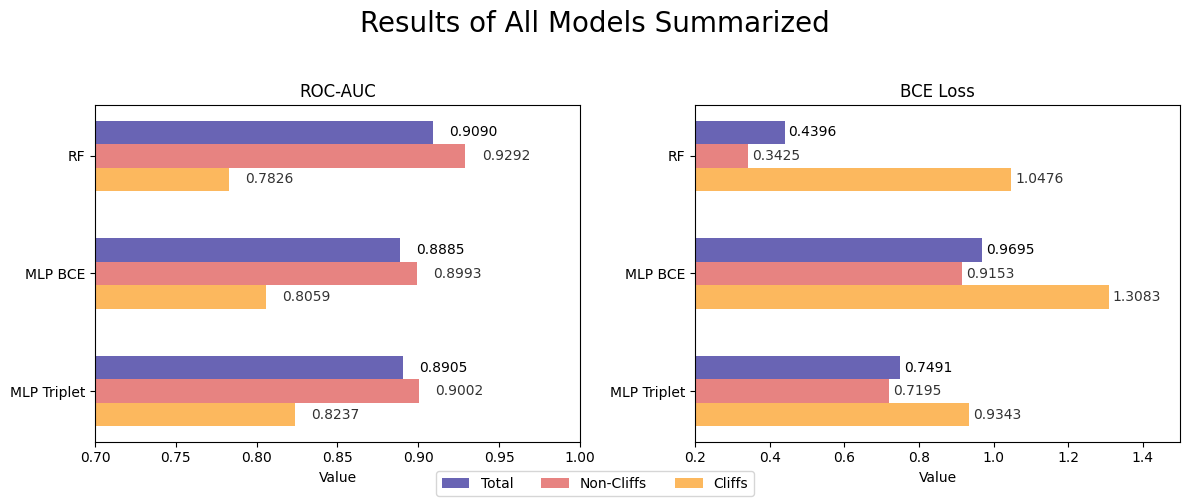

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Categories and values
categories = ["RF", "MLP BCE", "MLP Triplet"]
num_categories = len(categories)
y = np.arange(num_categories)

# Example data (replace with your real values)
values_roc_auc_total = [results_test[0]['ROC-AUC_mean'][0], results_test[1]['ROC-AUC_mean'][0], results_test[2]['ROC-AUC_mean'][0]]
values_roc_auc_non_cliffs = [results_test[0]['ROC-AUC_mean'][1], results_test[1]['ROC-AUC_mean'][1], results_test[2]['ROC-AUC_mean'][1]]
values_roc_auc_cliffs = [results_test[0]['ROC-AUC_mean'][2], results_test[1]['ROC-AUC_mean'][2], results_test[2]['ROC-AUC_mean'][2]]

values_bce_total = [results_test[0]['Loss_mean'][0], results_test[1]['Loss_mean'][0], results_test[2]['Loss_mean'][0]]
values_bce_non_cliffs = [results_test[0]['Loss_mean'][1], results_test[1]['Loss_mean'][1], results_test[2]['Loss_mean'][1]]
values_bce_cliffs = [results_test[0]['Loss_mean'][2], results_test[1]['Loss_mean'][2], results_test[2]['Loss_mean'][2]]

# Bar config
bar_height = 0.2
colors = [col_medium_blue, col_salmon, col_orange]
labels = ['Total', 'Non-Cliffs', 'Cliffs']

# Reverse category and data order so RF is at the top
categories = categories[::-1]
values_roc_auc_total = values_roc_auc_total[::-1]
values_roc_auc_non_cliffs = values_roc_auc_non_cliffs[::-1]
values_roc_auc_cliffs = values_roc_auc_cliffs[::-1]
values_bce_total = values_bce_total[::-1]
values_bce_non_cliffs = values_bce_non_cliffs[::-1]
values_bce_cliffs = values_bce_cliffs[::-1]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First plot - ROC-AUC
axs[0].barh(y + bar_height, values_roc_auc_total, height=bar_height, color=colors[0], label=labels[0])     # Top
axs[0].barh(y, values_roc_auc_non_cliffs, height=bar_height, color=colors[1], label=labels[1], alpha=0.8)             # Middle
axs[0].barh(y - bar_height, values_roc_auc_cliffs, height=bar_height, color=colors[2], label=labels[2], alpha=0.8)    # Bottom
axs[0].set_title('ROC-AUC')
axs[0].set_xlabel('Value')
axs[0].set_yticks(y)
axs[0].set_yticklabels(categories)
axs[0].set_xlim(0.7, 1.0)

# Annotate ROC-AUC bars
for i in range(num_categories):
    axs[0].text(values_roc_auc_total[i] + 0.01, y[i] + bar_height, f"{values_roc_auc_total[i]:.4f}", va='center')
    axs[0].text(values_roc_auc_non_cliffs[i] + 0.01, y[i], f"{values_roc_auc_non_cliffs[i]:.4f}", va='center', alpha=0.8)
    axs[0].text(values_roc_auc_cliffs[i] + 0.01, y[i] - bar_height, f"{values_roc_auc_cliffs[i]:.4f}", va='center', alpha=0.8)

# Second plot - BCE Loss
axs[1].barh(y + bar_height, values_bce_total, height=bar_height, color=colors[0])
axs[1].barh(y, values_bce_non_cliffs, height=bar_height, color=colors[1], alpha=0.8)
axs[1].barh(y - bar_height, values_bce_cliffs, height=bar_height, color=colors[2], alpha=0.8)
axs[1].set_title('BCE Loss')
axs[1].set_xlabel('Value')
axs[1].set_yticks(y)
axs[1].set_yticklabels(categories)
axs[1].set_xlim(0.2, 1.5)

# Annotate BCE Loss bars
for i in range(num_categories):
    axs[1].text(values_bce_total[i] + 0.01, y[i] + bar_height, f"{values_bce_total[i]:.4f}", va='center')
    axs[1].text(values_bce_non_cliffs[i] + 0.01, y[i], f"{values_bce_non_cliffs[i]:.4f}", va='center', alpha=0.8)
    axs[1].text(values_bce_cliffs[i] + 0.01, y[i] - bar_height, f"{values_bce_cliffs[i]:.4f}", va='center', alpha=0.8)

# Add shared legend
fig.legend(labels, loc='lower center', ncol=3)
fig.suptitle("Results of All Models Summarized", fontsize=20)

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("figures/total_results_bars.svg", format="svg")
output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "total_results_bars.pdf"), format="pdf")

plt.show()

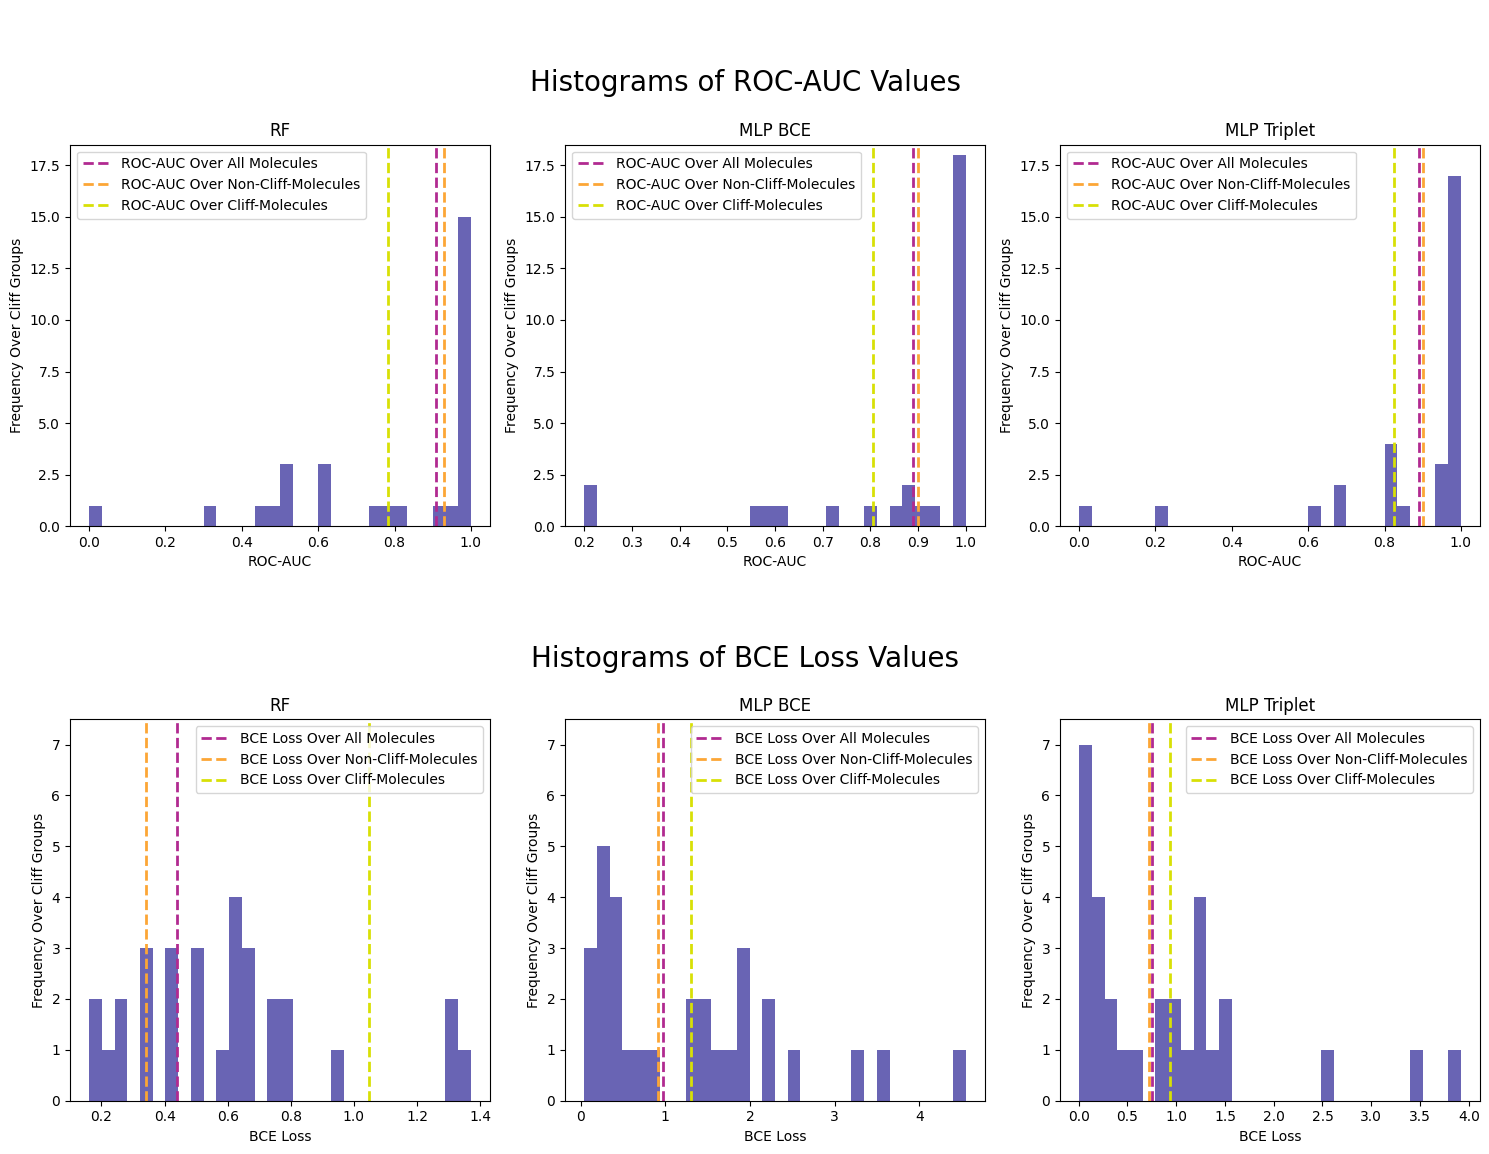

In [11]:
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.2, 1, 0.2, 1])  # subtitle + plots + subtitle + plots

# Subtitle for ROC-AUC
fig.add_subplot(gs[0, :]).axis("off")
fig.text(0.5, 0.92, "Histograms of ROC-AUC Values", ha='center', fontsize=20)

# ROC-AUC plots
for i, results in enumerate(results_networks):
    ax = fig.add_subplot(gs[1, i])
    ax.hist(results["ROC-AUC_mean"], bins=30, color=col_medium_blue)
    ax.set_title(network_titles[i])
    ax.set_xlabel("ROC-AUC")
    ax.set_ylabel("Frequency Over Cliff Groups")
    #ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 18.5)
    ax.axvline(x=results_test[i]['ROC-AUC_mean'][0], color=col_pink, linestyle='dashed', linewidth=2, label="ROC-AUC Over All Molecules")
    ax.axvline(x=results_test[i]['ROC-AUC_mean'][1], color=col_orange, linestyle='dashed', linewidth=2, label="ROC-AUC Over Non-Cliff-Molecules")
    ax.axvline(x=results_test[i]['ROC-AUC_mean'][2], color=col_yellow, linestyle='dashed', linewidth=2, label="ROC-AUC Over Cliff-Molecules")
    ax.legend()

# Subtitle for BCE-Loss
fig.add_subplot(gs[2, :]).axis("off")
fig.text(0.5, 0.44, "Histograms of BCE Loss Values", ha='center', fontsize=20)

# BCE-Loss plots
for i, results in enumerate(results_networks):
    ax = fig.add_subplot(gs[3, i])
    ax.hist(results["Loss_mean"], bins=30, color=col_medium_blue)
    ax.set_title(network_titles[i])
    ax.set_xlabel("BCE Loss")
    ax.set_ylabel("Frequency Over Cliff Groups")
    #ax.set_xlim(0, 5)
    ax.set_ylim(0, 7.5)
    ax.axvline(x=results_test[i]['Loss_mean'][0], color=col_pink, linestyle='dashed', linewidth=2, label="BCE Loss Over All Molecules")
    ax.axvline(x=results_test[i]['Loss_mean'][1], color=col_orange, linestyle='dashed', linewidth=2, label="BCE Loss Over Non-Cliff-Molecules")
    ax.axvline(x=results_test[i]['Loss_mean'][2], color=col_yellow, linestyle='dashed', linewidth=2, label="BCE Loss Over Cliff-Molecules")
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 1])
fig.savefig("figures/histograms.svg", format="svg")
output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "histograms.pdf"), format="pdf")

plt.show()

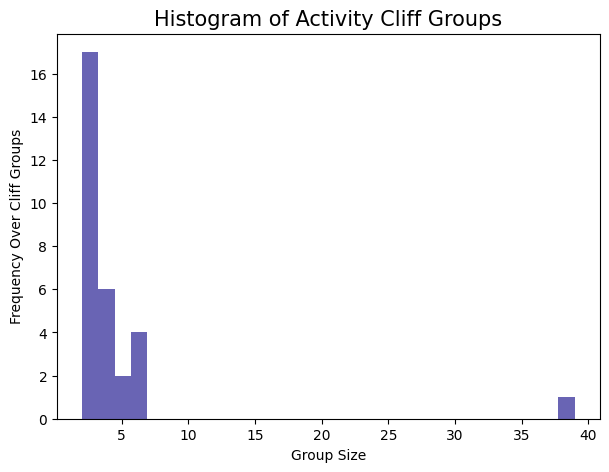

In [12]:
fig = plt.figure(figsize=(7, 5))

plt.hist(data_groups['Size_of_group'], bins=30, color=col_medium_blue)
plt.title("Histogram of Activity Cliff Groups", fontsize=15)
plt.xlabel("Group Size")
plt.ylabel("Frequency Over Cliff Groups")

fig.savefig("figures/histogram_group_sizes.svg", format="svg")
output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "histogram_group_sizes.pdf"), format="pdf")

plt.show()

In [13]:
# fig = plt.figure(figsize=(15, 12))
# gs = gridspec.GridSpec(4, 3, height_ratios=[0.2, 1, 0.2, 1])  # subtitle + plots + subtitle + plots

# # Subtitle for ROC-AUC
# fig.add_subplot(gs[0, :]).axis("off")
# fig.text(0.5, 0.92, "ROC-AUC vs. Percentage of Active Molecules", ha='center', fontsize=20)

# # ROC-AUC plots
# for i, results in enumerate(results_networks):
#     ax = fig.add_subplot(gs[1, i])
#     ax.scatter(data_groups['Percentage_active'], results["ROC-AUC_mean"], color=col_medium_blue)
#     ax.set_title(network_titles[i])
#     ax.set_xlabel("Percentage of Active Molecules")
#     ax.set_ylabel("ROC-AUC")
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1.1)

#     for j in range(len(results)):
#         ax.annotate(
#             str(j),  
#             (data_groups['Percentage_active'][j], results["ROC-AUC_mean"][j]),  # position of annotation
#             textcoords="offset points",  # offset the text
#             xytext=(2, 2),  # offset by 2 
#             fontsize=6,
#             color="grey"
#         )

# # Subtitle for BCE-Loss
# fig.add_subplot(gs[2, :]).axis("off")
# fig.text(0.5, 0.44, "BCE Loss vs. Percentage of Active Molecules", ha='center', fontsize=20)

# for i, results in enumerate(results_networks):
#     ax = fig.add_subplot(gs[3, i])
#     ax.scatter(data_groups['Percentage_active'], results["Loss_mean"], color=col_medium_blue)
#     ax.set_title(network_titles[i])
#     ax.set_xlabel("Percentage of Active Molecules")
#     ax.set_ylabel("BCE Loss")
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 5.5)

#     for j in range(len(results)):
#         ax.annotate(
#             str(j),  
#             (data_groups['Percentage_active'][j], results["Loss_mean"][j]),  # position of annotation
#             textcoords="offset points",  # offset the text
#             xytext=(2, 2),  # offset by 2 
#             fontsize=6,
#             color="grey"
#         )

# plt.tight_layout(rect=[0, 0.03, 1, 1])
# fig.savefig("figures/percentage_active.svg", format="svg")
# plt.show()

# output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
# os.makedirs(output_dir, exist_ok=True)
# drawing = svg2rlg("figures/percentage_active.svg")
# renderPDF.drawToFile(drawing, os.path.join(output_dir, "percentage_active.pdf"))

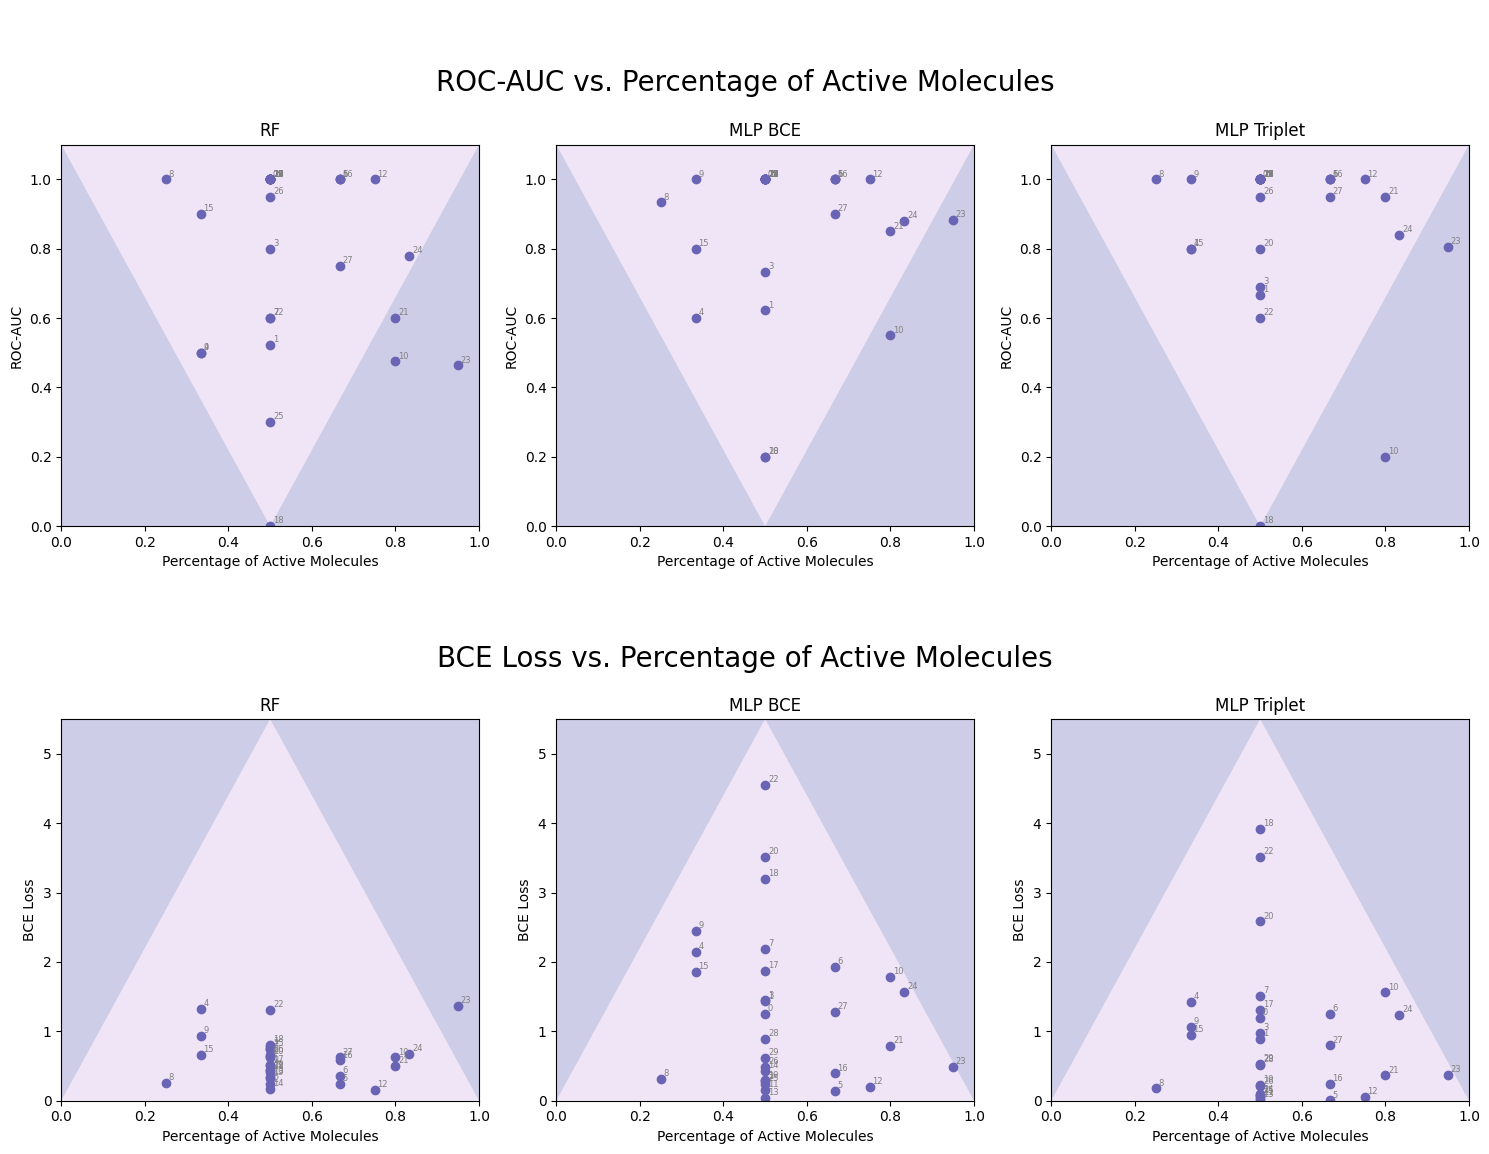

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

# Triangle background function
def add_background(ax, color, coords, alpha=0.3):
    polygon = Polygon(coords, closed=True, facecolor=color, edgecolor=None, alpha=alpha, zorder=0)
    ax.add_patch(polygon)

# Coordinates for top-row triangles (pyramid pointing up)
red_triangle_top = [(0, 1.1), (0.5, 0), (1, 1.1)]
yellow_left_top = [(0, 1.1), (0.5, 0), (0, 0)]
yellow_right_top = [(1, 1.1), (0.5, 0), (1, 0)]

# Coordinates for bottom-row triangles (pyramid pointing down)
red_triangle_bottom = [(0, 0), (0.5, 5.5), (1, 0)]
yellow_left_bottom = [(0, 0), (0.5, 5.5), (0, 5.5)]
yellow_right_bottom = [(1, 0), (0.5, 5.5), (5.5, 5.5)]

# Prepare figure
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.2, 1, 0.2, 1])  # subtitle + plots + subtitle + plots

# Subtitle for ROC-AUC
fig.add_subplot(gs[0, :]).axis("off")
fig.text(0.5, 0.92, "ROC-AUC vs. Percentage of Active Molecules", ha='center', fontsize=20)

# ROC-AUC plots (Top row)
for i, results in enumerate(results_networks):
    ax = fig.add_subplot(gs[1, i])

    # Background triangles
    add_background(ax, col_violet, red_triangle_top, alpha=0.1)
    add_background(ax, col_dark_blue, yellow_left_top, alpha=0.2)
    add_background(ax, col_dark_blue, yellow_right_top, alpha=0.2)

    ax.scatter(data_groups['Percentage_active'], results["ROC-AUC_mean"], color=col_medium_blue, zorder=1)
    ax.set_title(network_titles[i])
    ax.set_xlabel("Percentage of Active Molecules")
    ax.set_ylabel("ROC-AUC")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)

    for j in range(len(results)):
        ax.annotate(
            str(j),  
            (data_groups['Percentage_active'][j], results["ROC-AUC_mean"][j]),  
            textcoords="offset points",
            xytext=(2, 2),
            fontsize=6,
            color="grey"
        )

# Subtitle for BCE Loss
fig.add_subplot(gs[2, :]).axis("off")
fig.text(0.5, 0.44, "BCE Loss vs. Percentage of Active Molecules", ha='center', fontsize=20)

# BCE Loss plots (Bottom row)
for i, results in enumerate(results_networks):
    ax = fig.add_subplot(gs[3, i])

    # Background triangles
    add_background(ax, col_violet, red_triangle_bottom, alpha=0.1)
    add_background(ax, col_dark_blue, yellow_left_bottom, alpha=0.2)
    add_background(ax, col_dark_blue, yellow_right_bottom, alpha=0.2)

    ax.scatter(data_groups['Percentage_active'], results["Loss_mean"], color=col_medium_blue, zorder=1)
    ax.set_title(network_titles[i])
    ax.set_xlabel("Percentage of Active Molecules")
    ax.set_ylabel("BCE Loss")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 5.5)

    for j in range(len(results)):
        ax.annotate(
            str(j),  
            (data_groups['Percentage_active'][j], results["Loss_mean"][j]),  
            textcoords="offset points",
            xytext=(2, 2),
            fontsize=6,
            color="grey"
        )

plt.tight_layout(rect=[0, 0.03, 1, 1])
fig.savefig("figures/percentage_active.svg", format="svg")
fig.savefig(os.path.join(output_dir, "percentage_active.pdf"), format="pdf")
plt.show()

# # Export as PDF
# output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
# os.makedirs(output_dir, exist_ok=True)
# drawing = svg2rlg("figures/percentage_active.svg")
# renderPDF.drawToFile(drawing, os.path.join(output_dir, "percentage_active.pdf"))


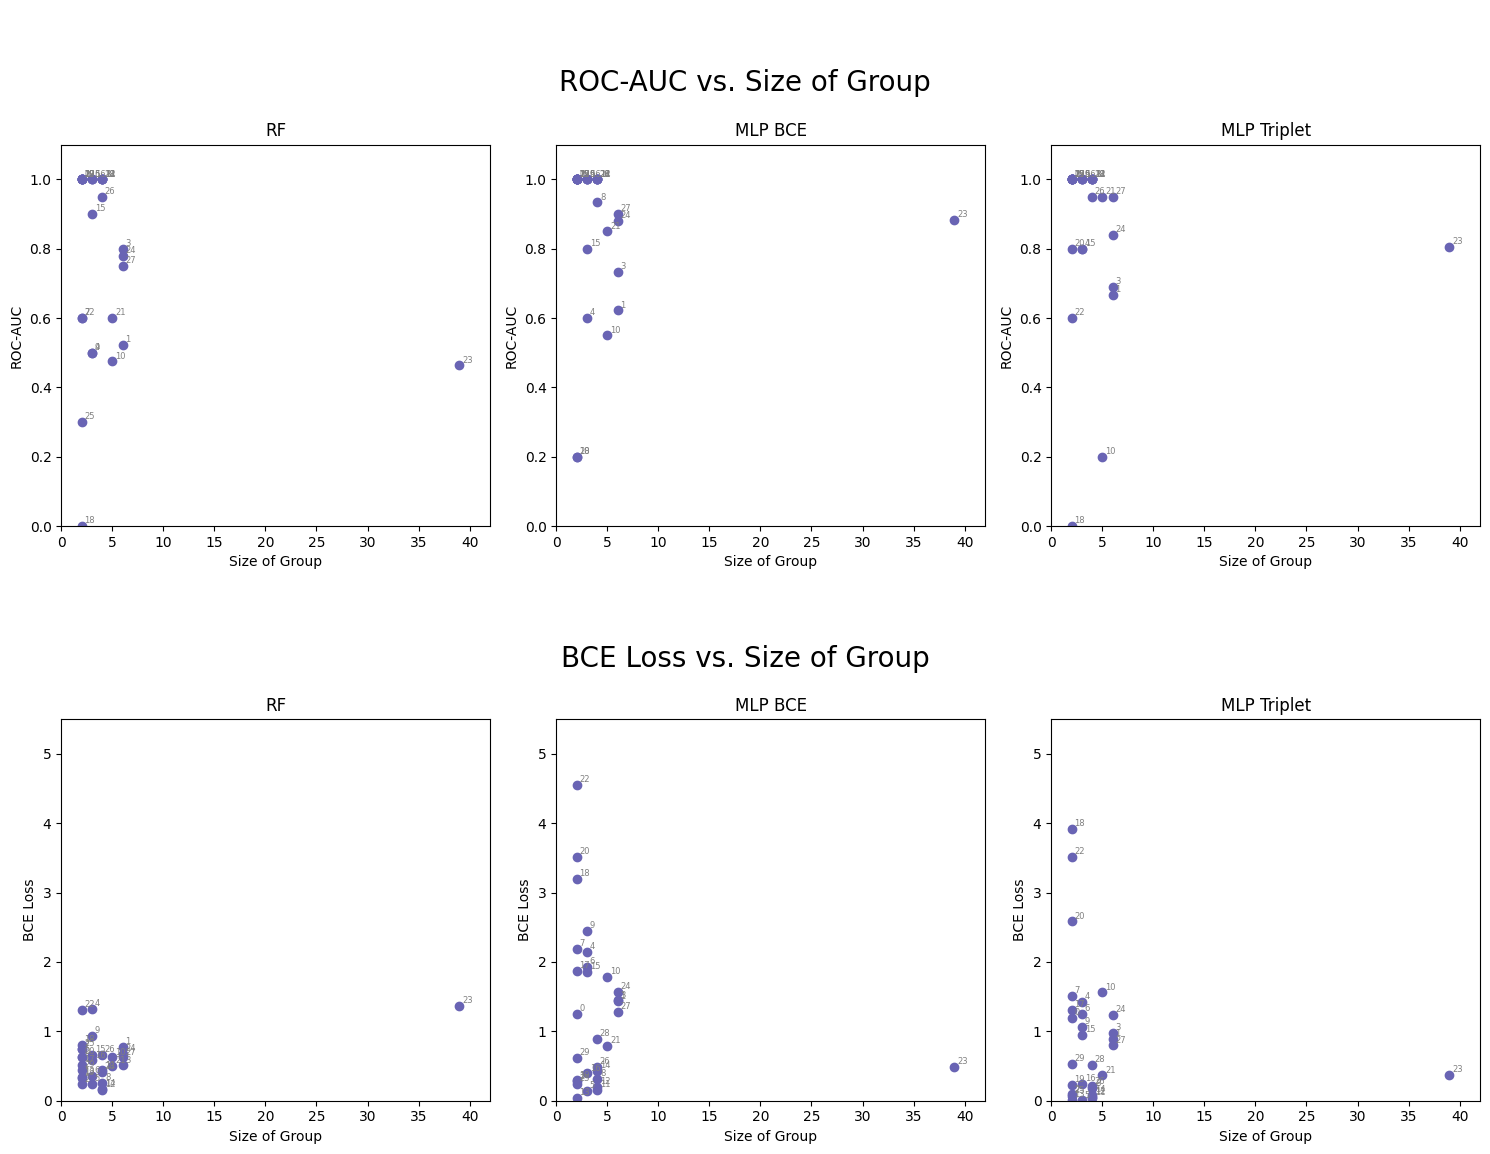

In [15]:
# NOT IN THESIS

fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.2, 1, 0.2, 1])  # subtitle + plots + subtitle + plots

# Subtitle for ROC-AUC
fig.add_subplot(gs[0, :]).axis("off")
fig.text(0.5, 0.92, "ROC-AUC vs. Size of Group", ha='center', fontsize=20)

# ROC-AUC plots
for i, results in enumerate(results_networks):
    ax = fig.add_subplot(gs[1, i])
    ax.scatter(data_groups['Size_of_group'], results["ROC-AUC_mean"], color=col_medium_blue)
    ax.set_title(network_titles[i])
    ax.set_xlabel("Size of Group")
    ax.set_ylabel("ROC-AUC")
    ax.set_xlim(0, 42)
    ax.set_ylim(0, 1.1)

    for j in range(len(results)):
        ax.annotate(
            str(j),  
            (data_groups['Size_of_group'][j], results["ROC-AUC_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

# Subtitle for BCE-Loss
fig.add_subplot(gs[2, :]).axis("off")
fig.text(0.5, 0.44, "BCE Loss vs. Size of Group", ha='center', fontsize=20)

for i, results in enumerate(results_networks):
    ax = fig.add_subplot(gs[3, i])
    ax.scatter(data_groups['Size_of_group'], results["Loss_mean"], color=col_medium_blue)
    ax.set_title(network_titles[i])
    ax.set_xlabel("Size of Group")
    ax.set_ylabel("BCE Loss")
    ax.set_xlim(0, 42)
    ax.set_ylim(0, 5.5)

    for j in range(len(results)):
        ax.annotate(
            str(j),  
            (data_groups['Size_of_group'][j], results["Loss_mean"][j]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=6,
            color="grey"
        )

plt.tight_layout(rect=[0, 0.03, 1, 1])
fig.savefig("figures/size_of_group.svg", format="svg")
output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "size_of_group.pdf"), format="pdf")

plt.show()


In [16]:
# def plot_pca(group_id, seed):

#     def str_to_array(x):
#         return np.array(json.loads(x), dtype=np.float32)


#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
#     class_colors = {0: 'blue', 1: 'red'}

#     for i, network in enumerate(networks_seeds[seed]):

#         filtered_df = df_test[df_test["cliff_group"] == group_id]

#         network.eval()
#         dataset = MoleculeACEDataset(filtered_df["ecfp"].apply(str_to_array), filtered_df['active'])
#         data_loader = DataLoader(dataset, batch_size=len(filtered_df))

#         samples, targets = next(iter(data_loader))
#         assert len(samples) == len(filtered_df)

#         outputs, emb = network(samples)

#         scaler = StandardScaler()
#         data_scaled = scaler.fit_transform(emb.detach().numpy())
#         pca = PCA(n_components=2)
#         principal_components = pca.fit_transform(data_scaled)

#         colors = filtered_df["active"].map(class_colors)

#         axes[i].scatter(principal_components[:, 0], principal_components[:, 1], c=colors)
#         axes[i].set_title(network_titles[i])
#         axes[i].set_xlabel("PC1")
#         axes[i].set_ylabel("PC2")

#     handles = [
#         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], markersize=10, label='Inactive'),
#         plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], markersize=10, label='Active')
#     ]
#     fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

#     fig.suptitle(f"PCA of Network Embeddings for Cliff Group {group_id}", fontsize=20)

#     plt.tight_layout()
#     plt.show()

In [17]:
# for i in range(len(group_dict)):
#     plot_pca(group_id=i, seed=12)
#     break

In [18]:
# for i in range(len(group_dict)):
#     plot_pca(group_id=i, seed=68)
#     break

In [19]:
# for i in range(len(group_dict)):
#     plot_pca(group_id=i, seed=94)
#     break

In [20]:
# for i in range(len(group_dict)):
#     plot_pca(group_id=i, seed=39)
#     break

In [21]:
# for i in range(len(group_dict)):
#     plot_pca(group_id=i, seed=7)
#     break

In [22]:
df_test = pd.read_csv("../data/" + dataset + "/df_test.csv")
group_dict = get_cliff_groups_test(path_to_test="../data/" + dataset + "/df_test.csv")
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_test['cliff_group'] = df_test.index.map(group_map)
df_test['cliff_group'] = df_test['cliff_group'].fillna(-1)
df_test['cliff_group'] = df_test['cliff_group'].astype(int)

df_test.head()

,smiles,exp_mean [nM],y,cliff_mol,split,y [pEC50/pKi],active,ecfp,cliff_mol_binary,similar_molecules,cliff_group
0,O=C(NCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cccc2c1-c1c...,36.00,-1.556303,1,test,7.443697,1,"[-0.06217700042172756, 3.0942948523831184, -0....",0,[4],-1
1,Fc1ccc(C(OC2CC3CCC(C2)N3Cc2ccc(Cl)c(Cl)c2)c2cc...,277.00,-2.442480,0,test,6.557520,0,"[-0.06217700042172756, 3.0942948523831184, -0....",0,[],-1
2,COc1ccc(NS(=O)(=O)c2ccc(Br)cc2)cc1N1CCN(C)CC1,794.33,-2.900001,0,test,6.099999,0,"[-0.06217700042172756, -0.3231754075504108, -0...",0,[],-1
3,Fc1ccc(C(OCCOC2CC3CCC(C2)N3)c2ccc(F)cc2)cc1,2520.00,-3.401401,0,test,5.598599,0,"[-0.06217700042172756, 3.0942948523831184, -0....",0,[],-1
4,O=C(NCCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cccc2c1-c...,28.00,-1.447158,0,test,7.552842,1,"[-0.06217700042172756, 3.0942948523831184, -0....",0,[0],-1


In [23]:
# plt.figure()

# def str_to_array(x):
#     return np.array(json.loads(x), dtype=np.float32)

# class_colors = {0: col_dark_blue, 1: col_salmon}

# ecfp_array = df_test["ecfp"].apply(str_to_array)
# ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

# pca = PCA(n_components=2)
# principal_components = pca.fit_transform(ecfp_array)

# colors = df_test["active"].map(class_colors)

# plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, s=15)
# plt.title("PCA of ECFP Representations")
# plt.xlabel("PC1")
# plt.ylabel("PC2")

# handles = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], markersize=10, label='Inactive'),
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], markersize=10, label='Active')
# ]
# plt.legend(handles=handles, loc='upper right', ncol=2)

# plt.tight_layout()

# fig.savefig("figures/pca_active_inactive.svg", format="svg")
# plt.show()

# output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
# os.makedirs(output_dir, exist_ok=True)
# drawing = svg2rlg("figures/pca_active_inactive.svg")
# renderPDF.drawToFile(drawing, os.path.join(output_dir, "pca_active_inactive.pdf"))

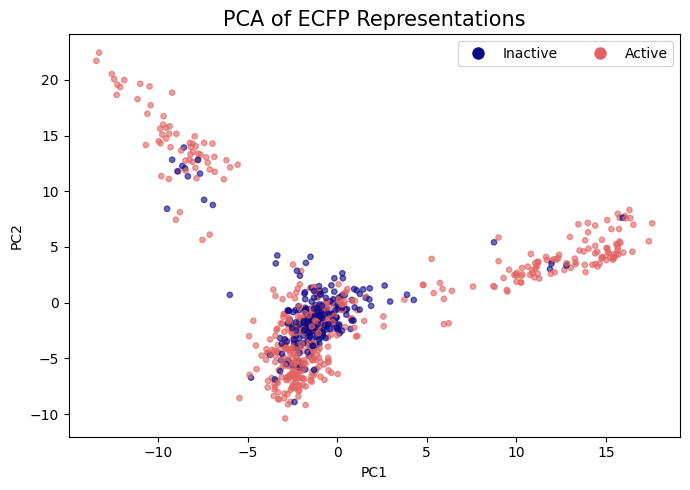

In [24]:
def str_to_array(x):
    return np.array(json.loads(x), dtype=np.float32)

class_colors = {0: col_dark_blue, 1: col_salmon}

ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)

fig, ax = plt.subplots(figsize=(7, 5))

colors = df_test["active"].map(class_colors)
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], 
                     c=colors, s=15, alpha=0.6)

ax.set_title("PCA of ECFP Representations", fontsize=15)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], 
               markersize=10, label='Inactive'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], 
               markersize=10, label='Active')
]
ax.legend(handles=handles, loc='upper right', ncol=2)

fig.tight_layout()

os.makedirs("figures", exist_ok=True)
svg_path = "figures/pca_active_inactive.svg"
fig.savefig(svg_path, format="svg", bbox_inches='tight')

output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
fig.savefig(os.path.join(output_dir, "pca_active_inactive.pdf"), format="pdf")

plt.show()

In [25]:
def plot_pca_ecfp(df_test, name):

    fig, ax = plt.subplots(figsize=(10, 6))

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    ecfp_array = df_test["ecfp"].apply(str_to_array)
    ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(ecfp_array)

    unique_classes = df_test["cliff_group"].unique()

    cmap = plt.get_cmap("gist_ncar", len(unique_classes))
    color_map = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
    color_map = {cls: cmap(i / len(unique_classes)) for i, cls in enumerate(unique_classes)}

    colors = df_test["cliff_group"].map(color_map)

    ax.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, alpha=0.4, s=15)
    ax.set_title("PCA of ECFP Representations", fontsize=15)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    for i, (x, y) in enumerate(principal_components):
        ax.annotate(
            str(df_test["cliff_group"].iloc[i]),  # Label
            (x, y),  # Position
            textcoords="offset points",
            xytext=(1.5, 1.5),  # Offset to avoid overlap
            fontsize=5,
            color="grey"
        )

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label="-1 (No Cliff)" if cls == -1 else str(cls))
        for cls in unique_classes
    ]
    legend = ax.legend(handles=handles, loc="center left", ncol=2, bbox_to_anchor=(1.02, 0.5), title="Cliff Group")

    plt.tight_layout()


    os.makedirs("figures", exist_ok=True)
    svg_path = "figures/" + name + ".svg"
    plt.savefig(svg_path, format="svg", bbox_inches='tight')
    output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, name + ".pdf"), format="pdf")

    plt.show()

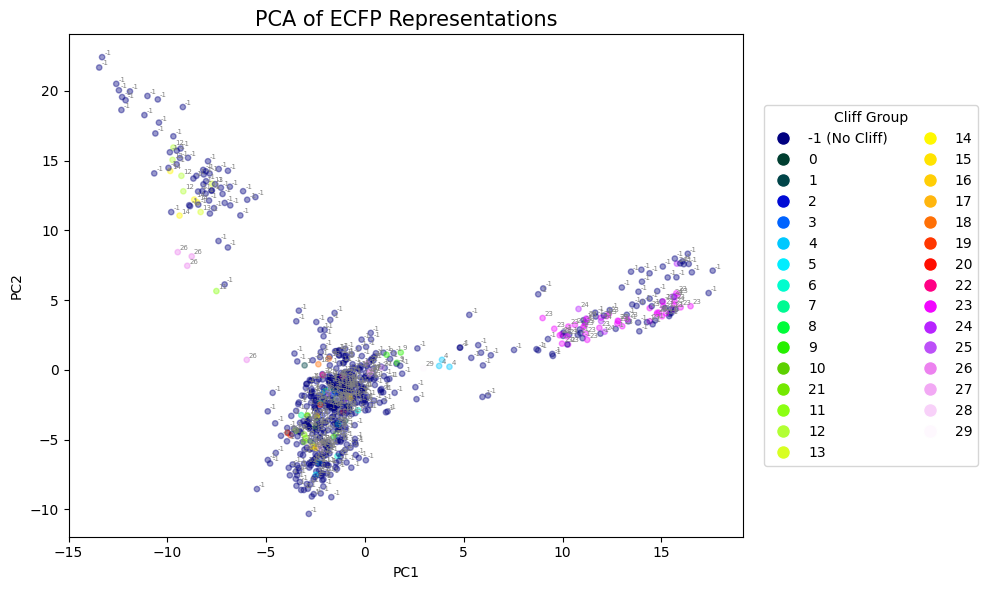

In [26]:
plot_pca_ecfp(df_test, name="pca_all_groups")

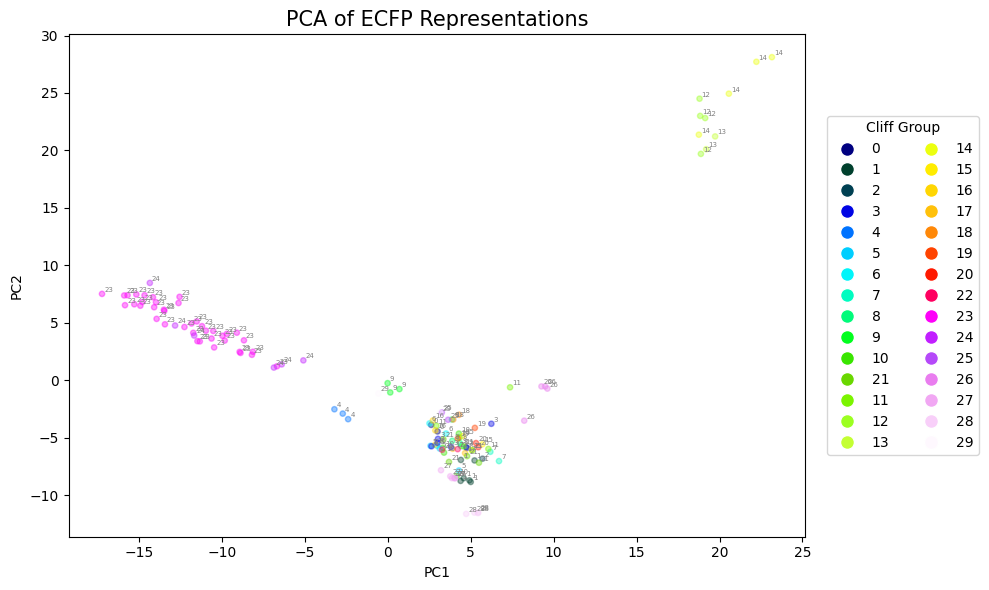

In [27]:
df_filtered = df_test[df_test["cliff_group"] != -1]

plot_pca_ecfp(df_filtered, "pca_cliff_groups")

In [28]:
# losses_per_datapoint_test_total = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_Manhattan.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_Cosine.csv")]
# losses_per_datapoint_test_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_Manhattan.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_Cosine.csv")]
# losses_per_datapoint_test_non_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_Manhattan.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_Cosine.csv")]
losses_per_datapoint_test_total = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_RF.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_MLP_Cosine.csv")]
losses_per_datapoint_test_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_RF.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Cliffs_MLP_Cosine.csv")]
losses_per_datapoint_test_non_cliffs = [pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_RF.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_BCE.csv"), pd.read_csv("../results/" + dataset + "/Loss_Per_Datapoint_Test_Non_Cliffs_MLP_Cosine.csv")]

In [29]:
def plot_pca_ecfp_with_loss_per_datapoint(df, losses, cliff_text, annotate_cliffs=False, name=""):

    assert len(df) == len(losses[0])

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(
        15, 5), gridspec_kw={"width_ratios": [1, 1, 1]})

    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    ecfp_array = df["ecfp"].apply(str_to_array)
    ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(ecfp_array)

    losses = [losses[0]['Loss_mean'].values.flatten(
    ), losses[1]['Loss_mean'].values.flatten(), losses[2]['Loss_mean'].values.flatten()]

    overall_min = min(losses[0].min(), losses[1].min(), losses[2].min())
    overall_max = max(losses[0].max(), losses[1].max(), losses[2].max())

    alpha = 0.3

    base_cmap = plt.colormaps["plasma"]
    colors_with_alpha = base_cmap(np.linspace(0, 1, 256))
    colors_with_alpha[:, 3] = alpha  # Set alpha transparency
    transparent_cmap = mcolors.ListedColormap(colors_with_alpha)
    norm = plt.Normalize(vmin=overall_min, vmax=overall_max)

    if annotate_cliffs:
        markers = {0: "x", 1: "o"}

        for i, (curr_losses, network_title) in enumerate(zip(losses, network_titles)):
            for cliff_value in [0, 1]:
                mask = df["cliff_mol_binary"] == cliff_value
                axes[i].scatter(
                    principal_components[mask, 0],
                    principal_components[mask, 1],
                    c=curr_losses[mask],
                    cmap=transparent_cmap,
                    alpha=alpha,
                    s=10,
                    marker=markers[cliff_value],
                    label="Cliff Molecule" if cliff_value == 1 else "Non-Cliff Molecule"
                )

            axes[i].set_title(network_title)
            axes[i].set_xlabel("PC1")
            axes[i].set_ylabel("PC2")

        fig.suptitle(f"PCA of ECFP Representations", fontsize=20)

    else:
        for i, (curr_losses, network_title) in enumerate(zip(losses, network_titles)):
            axes[i].scatter(principal_components[:, 0], principal_components[:, 1],
                            c=curr_losses, cmap=transparent_cmap, alpha=alpha, s=15)
            axes[i].set_title(network_title)
            axes[i].set_xlabel("PC1")
            axes[i].set_ylabel("PC2")

            # # Annotation of Cliff Groups
            # for j, (x, y) in enumerate(principal_components):
            #     axes[i].annotate(
            #         str(df["cliff_group"].iloc[j]),  # Label
            #         (x, y),  # Position
            #         textcoords="offset points",
            #         xytext=(1.5, 1.5),  # Offset to avoid overlap
            #         fontsize=5,
            #         color="grey"
            #     )

        fig.suptitle(f"PCA of ECFP Representations ({cliff_text})", fontsize=20)

    cbar = fig.colorbar(cm.ScalarMappable(cmap=transparent_cmap, norm=norm),
                        ax=axes[:], orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("BCE Loss of Datapoint")

    

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust layout to fit colorbar

    if annotate_cliffs:
        handles = [
            plt.Line2D([0], [0], marker='o', color='black',
                       linestyle='None', markersize=6, label='Cliff Molecule'),
            plt.Line2D([0], [0], marker='x', color='black',
                       linestyle='None', markersize=6, label='Non-Cliff Molecule')
        ]

        fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.45, -0.05), ncol=2)


    os.makedirs("figures", exist_ok=True)
    svg_path = "figures/" + name + ".svg"
    plt.savefig(svg_path, format="svg", bbox_inches='tight')
    

    output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
    os.makedirs(output_dir, exist_ok=True)
    # drawing = svg2rlg(svg_path)
    pdf_path = os.path.join(output_dir, name + ".pdf")
    # renderPDF.drawToFile(drawing, pdf_path)

    plt.savefig(pdf_path, format="pdf", bbox_inches='tight')

    plt.show()

C:\Users\lisak\AppData\Local\Temp\ipykernel_20588\371707263.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


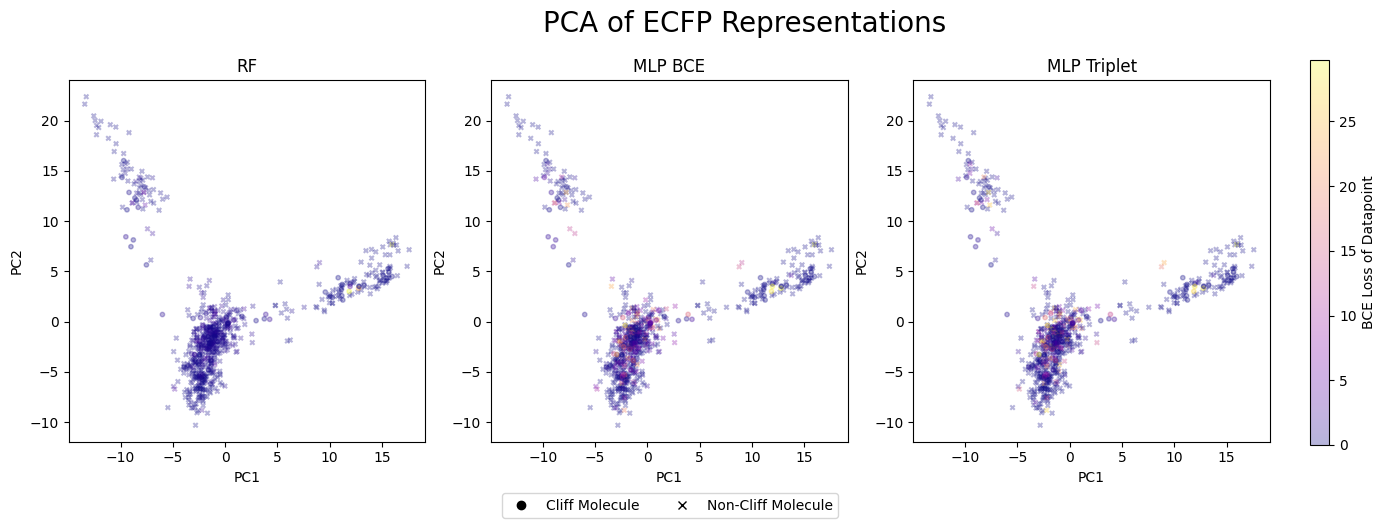

In [30]:
plot_pca_ecfp_with_loss_per_datapoint(df_test, losses_per_datapoint_test_total, "All Molecules", annotate_cliffs=True, name="pca_loss_per_datapoint")

C:\Users\lisak\AppData\Local\Temp\ipykernel_20588\2591914356.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


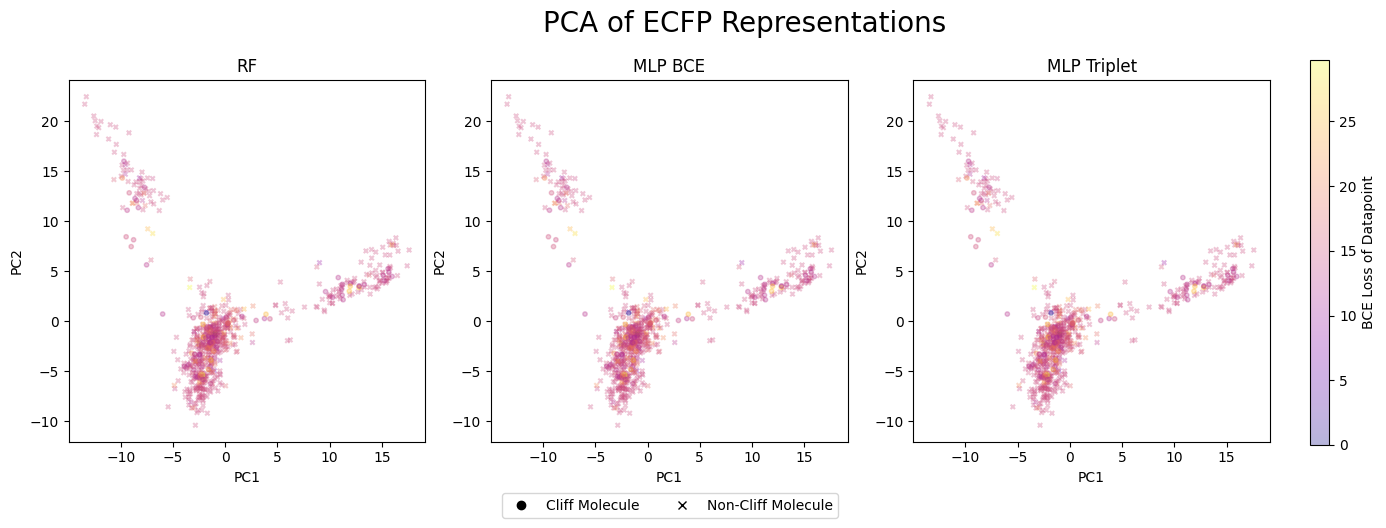

In [31]:
# NOT IN THESIS

assert len(df_test) == len(losses_per_datapoint_test_total[0])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(
    15, 5), gridspec_kw={"width_ratios": [1, 1, 1]})

def str_to_array(x):
    return np.array(json.loads(x), dtype=np.float32)

ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)

losses = [losses_per_datapoint_test_total[0]['Loss_mean'].values.flatten(
), losses_per_datapoint_test_total[1]['Loss_mean'].values.flatten(), losses_per_datapoint_test_total[2]['Loss_mean'].values.flatten()]

overall_min = min(losses[0].min(), losses[1].min(), losses[2].min())
overall_max = max(losses[0].max(), losses[1].max(), losses[2].max())

alpha = 0.3

base_cmap = plt.colormaps["plasma"]
colors_with_alpha = base_cmap(np.linspace(0, 1, 256))
colors_with_alpha[:, 3] = alpha  # Set alpha transparency
transparent_cmap = mcolors.ListedColormap(colors_with_alpha)
norm = plt.Normalize(vmin=overall_min, vmax=overall_max)

markers = {0: "x", 1: "o"}

for i, (curr_losses, network_title) in enumerate(zip(losses, network_titles)):
    for cliff_value in [0, 1]:
        mask = df_test["cliff_mol_binary"] == cliff_value
        axes[i].scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=losses[1][mask] - losses[2][mask],
            cmap=transparent_cmap,
            alpha=alpha,
            s=10,
            marker=markers[cliff_value],
            label="Cliff Molecule" if cliff_value == 1 else "Non-Cliff Molecule"
        )

    axes[i].set_title(network_title)
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")

fig.suptitle(f"PCA of ECFP Representations", fontsize=20)


cbar = fig.colorbar(cm.ScalarMappable(cmap=transparent_cmap, norm=norm),
                    ax=axes[:], orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label("BCE Loss of Datapoint")



plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust layout to fit colorbar

handles = [
    plt.Line2D([0], [0], marker='o', color='black',
                linestyle='None', markersize=6, label='Cliff Molecule'),
    plt.Line2D([0], [0], marker='x', color='black',
                linestyle='None', markersize=6, label='Non-Cliff Molecule')
]

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.45, -0.05), ncol=2)
plt.show()

C:\Users\lisak\AppData\Local\Temp\ipykernel_20588\371707263.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


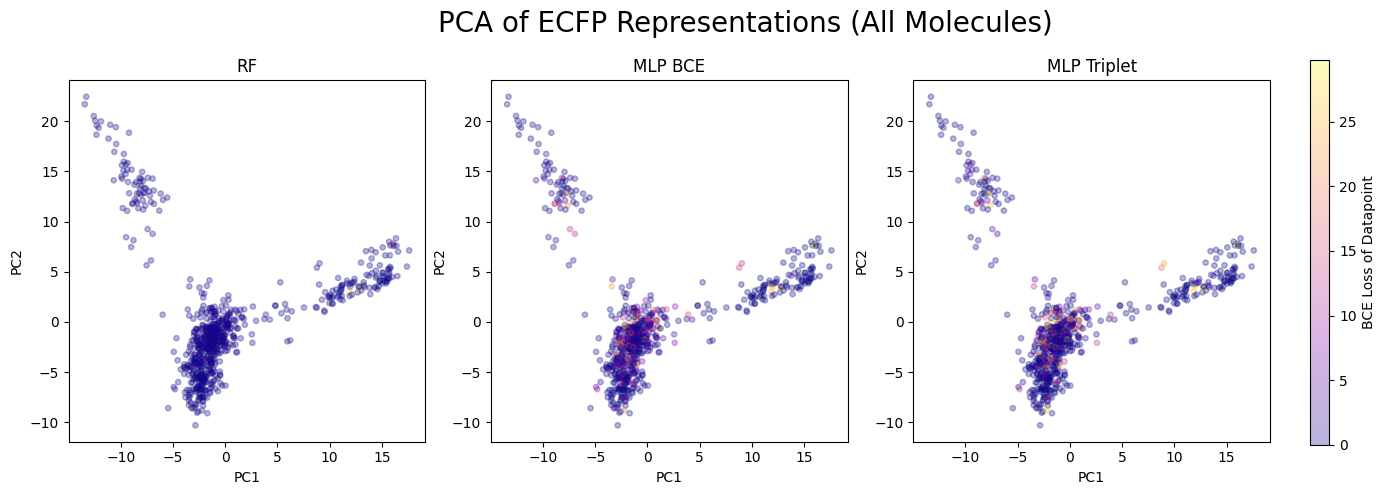

In [32]:
# NOT IN THESIS
plot_pca_ecfp_with_loss_per_datapoint(df_test, losses_per_datapoint_test_total, "All Molecules")

C:\Users\lisak\AppData\Local\Temp\ipykernel_20588\371707263.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


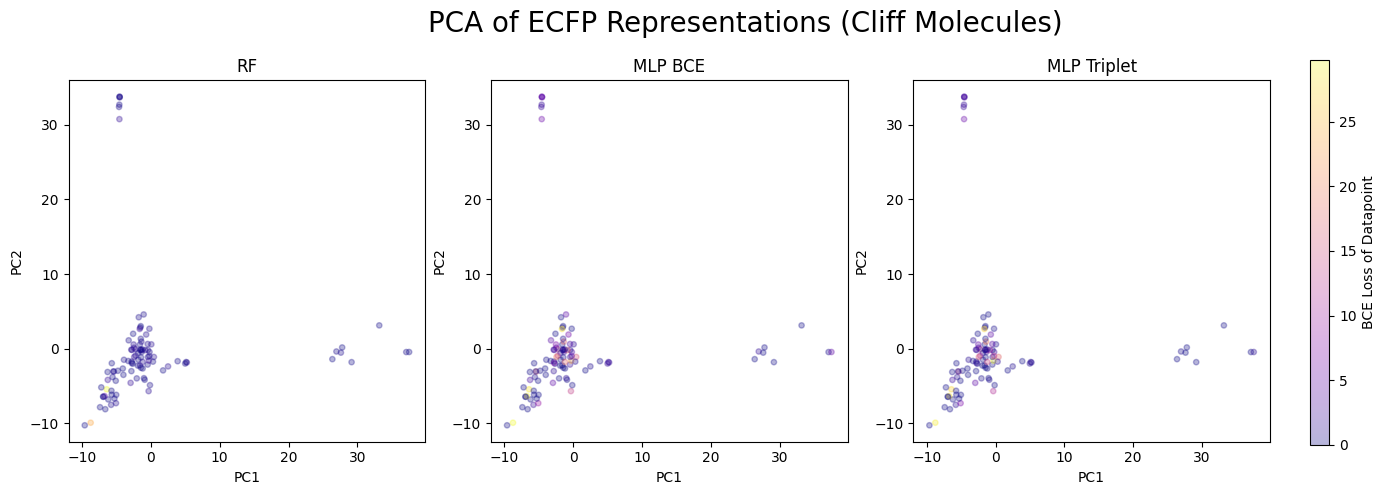

In [33]:
# NOT IN THESIS
df_filtered = df_test[df_test["cliff_mol_binary"] == 1]
plot_pca_ecfp_with_loss_per_datapoint(df_filtered, losses_per_datapoint_test_cliffs, "Cliff Molecules")

C:\Users\lisak\AppData\Local\Temp\ipykernel_20588\371707263.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


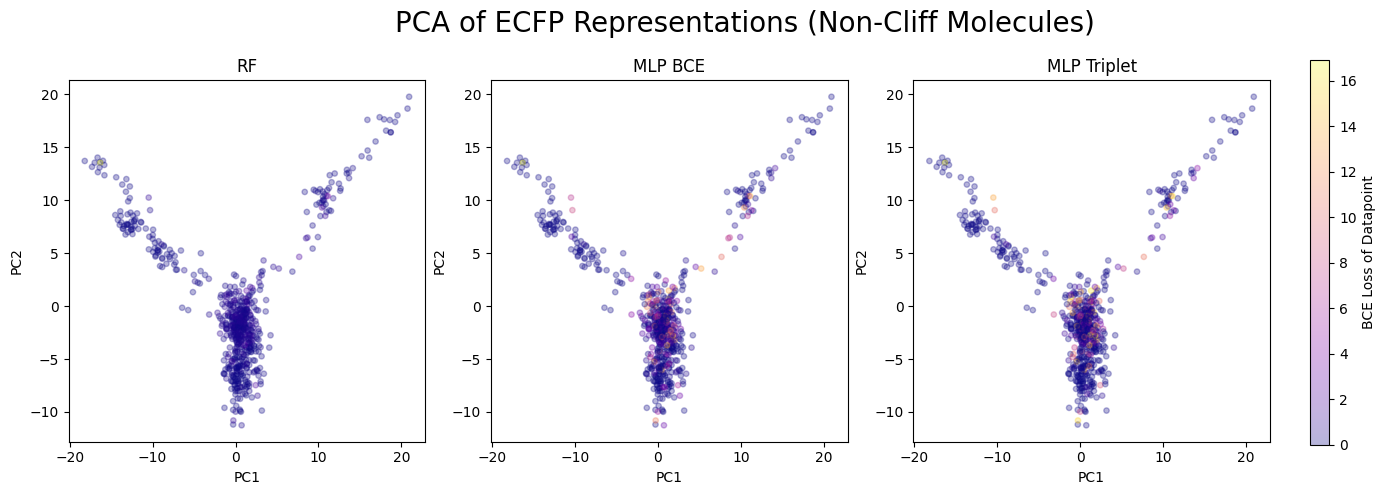

In [34]:
# NOT IN THESIS
df_filtered = df_test[df_test["cliff_mol_binary"] == 0]
plot_pca_ecfp_with_loss_per_datapoint(df_filtered, losses_per_datapoint_test_non_cliffs, "Non-Cliff Molecules")

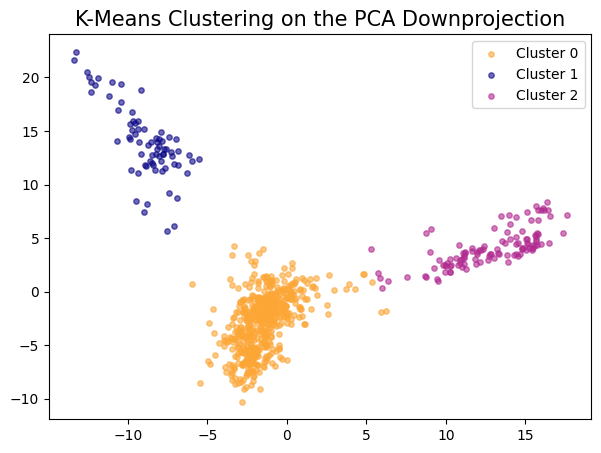

In [35]:
ecfp_array = df_test["ecfp"].apply(str_to_array)
ecfp_array = np.array([np.array(elem) for elem in ecfp_array])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(ecfp_array)

custom_colors = [col_orange, col_dark_blue, col_pink]

if dataset == "CHEMBL214_Ki":        
    kmeans = sklearn.cluster.KMeans(n_clusters=2, init=np.array([[-10, 25], 
                                                             [25, -5]]))
elif dataset == "CHEMBL234_Ki":
    kmeans = sklearn.cluster.KMeans(n_clusters=3)
else:
    raise Exception(f"No K-Means configuration defined for dataset '{dataset}'.")

labels = kmeans.fit_predict(principal_components)
np.save(f"../results/{dataset}/Clustering_Labels.npy", np.array(labels))

unique_labels = set(labels)
colors = [custom_colors[i] for i in range(len(unique_labels))]

plt.figure(figsize=(7, 5))
for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points are marked in black
        color = (0, 0, 0, 1) 

    plt.scatter(principal_components[labels == label, 0], principal_components[labels == label, 1], c=[color], label=f"Cluster {label}", s=15, alpha=0.6)

plt.legend()
plt.title("K-Means Clustering on the PCA Downprojection", fontsize=15)

name = "pca_clusters"
os.makedirs("figures", exist_ok=True)
svg_path = "figures/" + name + ".svg"
plt.savefig(svg_path, format="svg", bbox_inches='tight')

output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, name + ".pdf"), format="pdf", bbox_inches='tight')

# output_dir = "../../GIT Bachelor's Thesis (Writing)/images"
# os.makedirs(output_dir, exist_ok=True)
# drawing = svg2rlg(svg_path)
# pdf_path = os.path.join(output_dir, name + ".pdf")
# renderPDF.drawToFile(drawing, pdf_path)

plt.show()


In [36]:
results_clusters = []

results_clusters_rf = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_RF.csv")
results_clusters_cliffs_rf = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_RF.csv")
results_clusters_non_cliffs_rf = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_RF.csv")
results_clusters.append([results_clusters_rf, results_clusters_non_cliffs_rf, results_clusters_cliffs_rf])

results_clusters_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_BCE.csv")
results_clusters_cliffs_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_BCE.csv")
results_clusters_non_cliffs_mlp_bce = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_BCE.csv")
results_clusters.append([results_clusters_mlp_bce, results_clusters_non_cliffs_mlp_bce, results_clusters_cliffs_mlp_bce])

# results_clusters_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_Manhattan.csv")
# results_clusters_cliffs_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_Manhattan.csv")
# results_clusters_non_cliffs_mlp_manhattan = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_Manhattan.csv")
# results_clusters.append([results_clusters_mlp_manhattan, results_clusters_non_cliffs_mlp_manhattan, results_clusters_cliffs_mlp_manhattan])

results_clusters_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_MLP_Cosine.csv")
results_clusters_cliffs_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Cliffs_MLP_Cosine.csv")
results_clusters_non_cliffs_mlp_cosine = pd.read_csv("../results/" + dataset + "/Results_Clusters_Test_Non_Cliffs_MLP_Cosine.csv")
results_clusters.append([results_clusters_mlp_cosine, results_clusters_non_cliffs_mlp_cosine, results_clusters_cliffs_mlp_cosine])

In [37]:
prop_ac_total = len(df_test[df_test["cliff_mol_binary"] == 1]) / len(df_test)

df_filtered = df_test.iloc[np.where(labels == 0)]
prop_ac_cluster0 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

df_filtered = df_test.iloc[np.where(labels == 1)]
prop_ac_cluster1 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

if dataset == 'CHEMBL234_Ki':
    df_filtered = df_test.iloc[np.where(labels == 2)]
    prop_ac_cluster2 = len(df_filtered[df_filtered["cliff_mol_binary"] == 1]) / len(df_filtered)

In [38]:
size_total = len(df_test)

df_filtered = df_test.iloc[np.where(labels == 0)]
size_cluster_0 = len(df_filtered)

df_filtered = df_test.iloc[np.where(labels == 1)]
size_cluster_1 = len(df_filtered)

if dataset == 'CHEMBL234_Ki':
    df_filtered = df_test.iloc[np.where(labels == 2)]
    size_cluster_2 = len(df_filtered)

In [39]:
tables_clusters = []
overall_results_test_set = []

def round_list(values, decimals=4):
    return [round(v, decimals) for v in values]

for i in range(3):
    curr_tables = results_clusters[i]  # RF, MLP BCE, MLP Cosine
    results_total, results_non_cliffs, results_cliffs = curr_tables

    curr_overall_results = results_test[i]

    if dataset == 'CHEMBL234_Ki':
        table_cluster = {
            "Cluster": ["Dataset", "Cluster0", "Cluster1", "Cluster 2"],
            "Number of Molecules": round_list([size_total, size_cluster_0, size_cluster_1, size_cluster_2], 6),

            "Proportion of ACs": round_list([prop_ac_total, prop_ac_cluster0, prop_ac_cluster1, prop_ac_cluster2], 6),

            "ROC-AUC (all molecules)": round_list([curr_overall_results['ROC-AUC_mean'][0], results_total['ROC-AUC_mean'][0], 
                                        results_total['ROC-AUC_mean'][1], results_total['ROC-AUC_mean'][2]]),
            "ROC-AUC (non-cliff molecules)": round_list([curr_overall_results['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][0], 
                                        results_non_cliffs['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][2]]),
            "ROC-AUC (cliff molecules)": round_list([curr_overall_results['ROC-AUC_mean'][2], results_cliffs['ROC-AUC_mean'][0], 
                                        results_cliffs['ROC-AUC_mean'][1], results_cliffs['ROC-AUC_mean'][2]]),     
                                        
                                        
            "BCE Loss (all molecules)": round_list([curr_overall_results['Loss_mean'][0], results_total['Loss_mean'][0], 
                                        results_total['Loss_mean'][1], results_total['Loss_mean'][2]]),
            "BCE Loss (non-cliff molecules)": round_list([curr_overall_results['Loss_mean'][1], results_non_cliffs['Loss_mean'][0], 
                                        results_non_cliffs['Loss_mean'][1], results_non_cliffs['Loss_mean'][2]]),
            "BCE Loss (cliff molecules)": round_list([curr_overall_results['Loss_mean'][2], results_cliffs['Loss_mean'][0], 
                                        results_cliffs['Loss_mean'][1], results_cliffs['Loss_mean'][2]]),  
        }

    elif dataset == 'CHEMBL214_Ki':
        table_cluster = {
            "Cluster": ["Dataset", "Cluster0", "Cluster1"],
            "Proportion of ACs": [prop_ac_total, prop_ac_cluster0, prop_ac_cluster1],

            "BCE Loss (all molecules)": [curr_overall_results['Loss_mean'][0], results_total['Loss_mean'][0], 
                                        results_total['Loss_mean'][1]],
            "BCE Loss (non-cliff molecules)": [curr_overall_results['Loss_mean'][1], results_non_cliffs['Loss_mean'][0], 
                                        results_non_cliffs['Loss_mean'][1]],
            "BCE Loss (cliff molecules)": [curr_overall_results['Loss_mean'][2], results_cliffs['Loss_mean'][0], 
                                        results_cliffs['Loss_mean'][1]],  

            "ROC-AUC (all molecules)": [curr_overall_results['ROC-AUC_mean'][0], results_total['ROC-AUC_mean'][0], 
                                        results_total['ROC-AUC_mean'][1]],
            "ROC-AUC (non-cliff molecules)": [curr_overall_results['ROC-AUC_mean'][1], results_non_cliffs['ROC-AUC_mean'][0], 
                                        results_non_cliffs['ROC-AUC_mean'][1]],
            "ROC-AUC (cliff molecules)": [curr_overall_results['ROC-AUC_mean'][2], results_cliffs['ROC-AUC_mean'][0], 
                                        results_cliffs['ROC-AUC_mean'][1]],                        

        }

    table_cluster = pd.DataFrame(table_cluster)

    tables_clusters.append(table_cluster)



In [40]:
print("RF:")
tables_clusters[0]

RF:


,Cluster,Number of Molecules,Proportion of ACs,ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules),BCE Loss (all molecules),BCE Loss (non-cliff molecules),BCE Loss (cliff molecules)
0,Dataset,733,0.137790,0.9090,0.9292,0.7826,0.4396,0.3425,1.0476
1,Cluster0,547,0.127971,0.8978,0.9176,0.7207,0.4065,0.3725,0.6386
2,Cluster1,73,0.164384,0.5674,0.7283,0.5708,0.6936,0.2239,3.0174
3,Cluster 2,113,0.168142,0.8578,0.7645,0.9886,0.2947,0.2908,0.3146


In [41]:
print("MLP BCE:")
tables_clusters[1]

MLP BCE:


,Cluster,Number of Molecules,Proportion of ACs,ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules),BCE Loss (all molecules),BCE Loss (non-cliff molecules),BCE Loss (cliff molecules)
0,Dataset,733,0.137790,0.8885,0.8993,0.8059,0.9695,0.9153,1.3083
1,Cluster0,547,0.127971,0.8694,0.8818,0.7458,1.1049,1.0578,1.4259
2,Cluster1,73,0.164384,0.7604,0.6527,0.8271,0.4562,0.2487,1.4828
3,Cluster 2,113,0.168142,0.8499,0.7661,0.9943,0.7492,0.8285,0.3460


In [42]:
print("MLP Cosine:")
tables_clusters[2]

MLP Cosine:


,Cluster,Number of Molecules,Proportion of ACs,ROC-AUC (all molecules),ROC-AUC (non-cliff molecules),ROC-AUC (cliff molecules),BCE Loss (all molecules),BCE Loss (non-cliff molecules),BCE Loss (cliff molecules)
0,Dataset,733,0.137790,0.8905,0.9002,0.8237,0.7491,0.7195,0.9343
1,Cluster0,547,0.127971,0.8768,0.8882,0.7861,0.8520,0.8278,1.0173
2,Cluster1,73,0.164384,0.6543,0.4516,0.7625,0.3817,0.2244,1.1600
3,Cluster 2,113,0.168142,0.8604,0.7848,1.0000,0.5465,0.6357,0.0932
